In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
from multiprocessing import Pool

In [2]:
data = pd.read_parquet('filled_cu.parquet')
data.dropna(inplace=True)
data

,DateTime,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,...,BidPrice4,BidVolume4,AskPrice4,AskVolume4,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover
1,2023-01-03 09:00:00.500,20230103.0,66240.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99669.0,...,66160.0,160.0,66270.0,2.0,66150.0,353.0,66280.0,1.0,21.0,6952600.0
2,2023-01-03 09:00:01.000,20230103.0,66210.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99682.0,...,66160.0,161.0,66260.0,102.0,66150.0,353.0,66270.0,2.0,56.0,18541250.0
3,2023-01-03 09:00:01.500,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99681.0,...,66200.0,27.0,66270.0,3.0,66170.0,64.0,66280.0,1.0,14.0,4636150.0
4,2023-01-03 09:00:02.000,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99672.0,...,66200.0,28.0,66300.0,56.0,66170.0,63.0,66310.0,1.0,29.0,9603500.0
5,2023-01-03 09:00:02.500,20230103.0,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99671.0,...,66170.0,63.0,66270.0,3.0,66160.0,163.0,66280.0,1.0,18.0,5961050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20787477,2023-12-29 23:59:57.500,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787478,2023-12-29 23:59:58.000,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787479,2023-12-29 23:59:58.500,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0
20787480,2023-12-29 23:59:59.000,20231229.0,69040.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150584.0,...,69000.0,85.0,69080.0,28.0,68990.0,30.0,69090.0,26.0,0.0,0.0


In [3]:
data.columns

Index(['DateTime', 'TradingDay', 'LastPrice', 'PreSettlementPrice',
       'PreClosePrice', 'PreOpenInterest', 'OpenPrice', 'HighestPrice',
       'LowestPrice', 'OpenInterest', 'BidPrice1', 'BidVolume1', 'AskPrice1',
       'AskVolume1', 'BidPrice2', 'BidVolume2', 'AskPrice2', 'AskVolume2',
       'BidPrice3', 'BidVolume3', 'AskPrice3', 'AskVolume3', 'BidPrice4',
       'BidVolume4', 'AskPrice4', 'AskVolume4', 'BidPrice5', 'BidVolume5',
       'AskPrice5', 'AskVolume5', 'delta_Volume', 'delta_Turnover'],
      dtype='object')

- 价格均值因子：结合 bid 和 ask 价格求出不同价位的加权平均价格，用来反映市场的整体价格水平。
$$
mid\_price = (BidPrice1 + AskPrice1) / 2
$$
$$
spread = AskPrice1 - BidPrice1
$$

In [4]:
data['vwap'] = data['delta_Turnover']/(data['delta_Volume']*5)
data['vwap'] = data['vwap'].fillna(0)
data['mid_price'] = (data['BidPrice1'] + data['AskPrice1'])/2
data['spread'] = data['AskPrice1'] - data['BidPrice1']
data['label'] = 100*(data['mid_price'].shift(-120)-data['mid_price'])/data['mid_price']
data.dropna(subset='label', inplace=True)
data['TradingDay'] = pd.to_datetime(data['TradingDay'].astype('int'), format='%Y%m%d')
data


,DateTime,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,...,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover,vwap,mid_price,spread,label
1,2023-01-03 09:00:00.500,2023-01-03,66240.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99669.0,...,66150.0,353.0,66280.0,1.0,21.0,6952600.0,66215.238095,66225.0,30.0,-0.045300
2,2023-01-03 09:00:01.000,2023-01-03,66210.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99682.0,...,66150.0,353.0,66270.0,2.0,56.0,18541250.0,66218.750000,66220.0,20.0,-0.030202
3,2023-01-03 09:00:01.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99681.0,...,66170.0,64.0,66280.0,1.0,14.0,4636150.0,66230.714286,66235.0,10.0,-0.045293
4,2023-01-03 09:00:02.000,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99672.0,...,66170.0,63.0,66310.0,1.0,29.0,9603500.0,66231.034483,66245.0,30.0,-0.075477
5,2023-01-03 09:00:02.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99671.0,...,66160.0,163.0,66280.0,1.0,18.0,5961050.0,66233.888889,66225.0,10.0,-0.045300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20787357,2023-12-29 23:58:57.500,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787358,2023-12-29 23:58:58.000,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787359,2023-12-29 23:58:58.500,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243
20787360,2023-12-29 23:58:59.000,2023-12-29,69030.0,69500.0,69340.0,155933.0,68970.0,69150.0,68920.0,150580.0,...,68990.0,32.0,69080.0,29.0,0.0,0.0,0.000000,69035.0,10.0,0.007243


In [5]:
data = data[(data['DateTime'].dt.hour>=9)&(data['DateTime'].dt.hour<14)|((data['DateTime'].dt.hour==14)&(data['DateTime'].dt.minute<55))]
data.reset_index(drop=True)
data

,DateTime,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,...,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover,vwap,mid_price,spread,label
1,2023-01-03 09:00:00.500,2023-01-03,66240.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99669.0,...,66150.0,353.0,66280.0,1.0,21.0,6952600.0,66215.238095,66225.0,30.0,-0.045300
2,2023-01-03 09:00:01.000,2023-01-03,66210.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99682.0,...,66150.0,353.0,66270.0,2.0,56.0,18541250.0,66218.750000,66220.0,20.0,-0.030202
3,2023-01-03 09:00:01.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66240.0,66160.0,99681.0,...,66170.0,64.0,66280.0,1.0,14.0,4636150.0,66230.714286,66235.0,10.0,-0.045293
4,2023-01-03 09:00:02.000,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99672.0,...,66170.0,63.0,66310.0,1.0,29.0,9603500.0,66231.034483,66245.0,30.0,-0.075477
5,2023-01-03 09:00:02.500,2023-01-03,66230.0,66120.0,66260.0,99641.0,66160.0,66250.0,66160.0,99671.0,...,66160.0,163.0,66280.0,1.0,18.0,5961050.0,66233.888889,66225.0,10.0,-0.045300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20765276,2023-12-29 14:54:57.500,2023-12-29,68920.0,69500.0,69340.0,155933.0,68970.0,69150.0,68810.0,144757.0,...,68870.0,41.0,68960.0,34.0,0.0,0.0,0.000000,68915.0,10.0,0.000000
20765277,2023-12-29 14:54:58.000,2023-12-29,68920.0,69500.0,69340.0,155933.0,68970.0,69150.0,68810.0,144757.0,...,68870.0,41.0,68960.0,34.0,0.0,0.0,0.000000,68915.0,10.0,-0.014511
20765278,2023-12-29 14:54:58.500,2023-12-29,68920.0,69500.0,69340.0,155933.0,68970.0,69150.0,68810.0,144757.0,...,68870.0,41.0,68960.0,34.0,0.0,0.0,0.000000,68915.0,10.0,-0.014511
20765279,2023-12-29 14:54:59.000,2023-12-29,68920.0,69500.0,69340.0,155933.0,68970.0,69150.0,68810.0,144757.0,...,68870.0,41.0,68960.0,34.0,0.0,0.0,0.000000,68915.0,10.0,-0.014511


In [6]:
def cal_ic(factor):
    daily_ic = data.groupby('TradingDay').apply(lambda x: x[factor].corr(x['label']))
    return daily_ic

- 买盘深度（Bid Depth）：
$$
\text{bid\_depth} = \sum_{i=1}^{N} \text{BidVolume}_i
$$
- 卖盘深度（Ask Depth）：
$$
\text{ask\_depth} = \sum_{i=1}^{N} \text{AskVolume}_i
$$
- 总深度：
$$
\text{total\_depth} = \text{bid\_depth} + \text{ask\_depth}
$$

In [7]:
data['bid_depth'] = data['BidVolume1']+data['BidVolume2']+data['BidVolume3']+data['BidVolume4']+data['BidVolume5']
data['ask_depth'] = data['AskVolume1']+data['AskVolume2']+data['AskVolume3']+data['AskVolume4']+data['AskVolume5']
data['total_depth'] = data['bid_depth'] + data['ask_depth'] 

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1137248550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bid_depth'] = data['BidVolume1']+data['BidVolume2']+data['BidVolume3']+data['BidVolume4']+data['BidVolume5']
/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1137248550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ask_depth'] = data['AskVolume1']+data['AskVolume2']+data['AskVolume3']+data['AskVolume4']+data['AskVolume5']
/var/folders/l5/7228dqmd12

买卖力量比率衡量了买盘和卖盘之间的力量对比。通过计算买卖盘的订单数量差异，可以判断市场情绪。

- 买卖力量比率：

$$
\text{order\_imbalance} = \frac{\text{bid\_depth} - \text{ask\_depth}}{\text{bid\_depth} + \text{ask\_depth}}
$$

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/2988289188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['order_imbalance'] = (data['bid_depth']-data['ask_depth'])/(data['bid_depth']+data['ask_depth'])


0.051114759011894585

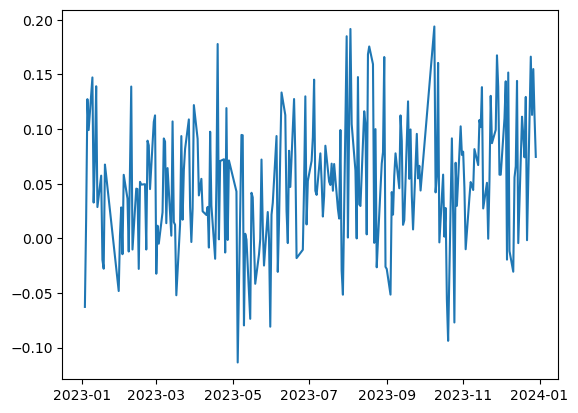

In [8]:
data['order_imbalance'] = (data['bid_depth']-data['ask_depth'])/(data['bid_depth']+data['ask_depth'])
plt.plot(cal_ic('order_imbalance'))
cal_ic('order_imbalance').mean()

1. 移动平均的 Order Imbalance 因子

通过计算过去  n  个时间窗口的 Order Imbalance 移动平均，捕捉买卖不平衡的趋势。移动平均可以平滑因子的短期波动，使其更具稳定性。

$$
\text{OI\_MA}_n = \frac{1}{n} \sum_{i=t-n+1}^{t} \text{Order Imbalance}_{i}
$$


/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/603000351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_MA_10'] = data['order_imbalance'].rolling(window=10).mean()


0.03270092907315296

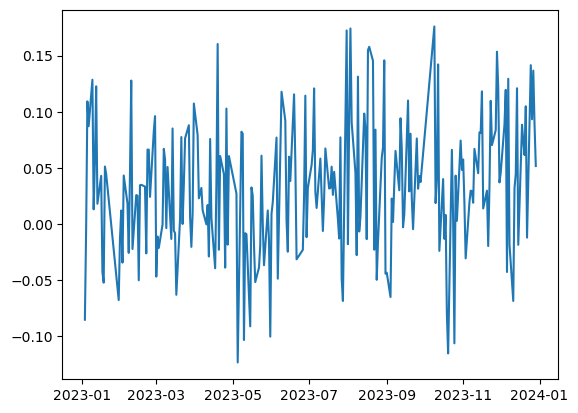

In [9]:
data['OI_MA_10'] = data['order_imbalance'].rolling(window=10).mean()
plt.plot(cal_ic('OI_MA_10'))
cal_ic('OI_MA_10').mean()

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/3528093680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_MA_120'] = data['order_imbalance'].rolling(window=120).mean()


0.01613146933559736

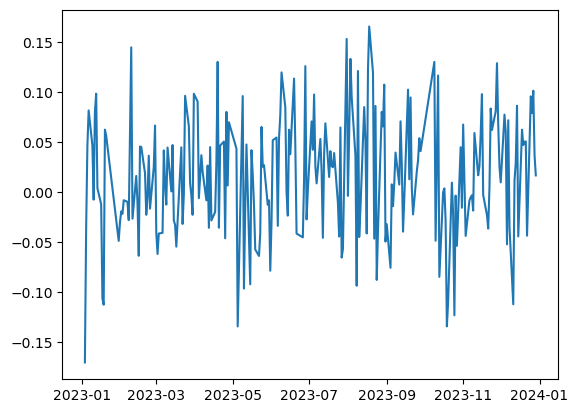

In [10]:
data['OI_MA_120'] = data['order_imbalance'].rolling(window=120).mean()
plt.plot(cal_ic('OI_MA_120'))
cal_ic('OI_MA_120').mean()

Order Imbalance 的变化率因子（Momentum of Order Imbalance）

计算当前 Order Imbalance 相对于过去几个窗口的变化率（动量），用来捕捉不平衡因子的趋势变化。

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1682689818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_momentum_10'] = data['order_imbalance'].diff(10)


0.06811345792513439

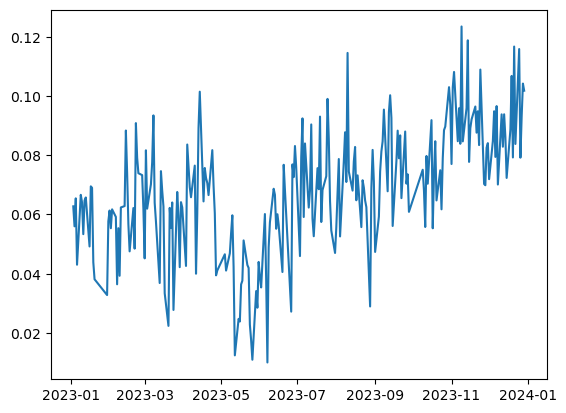

In [11]:
data['OI_momentum_10'] = data['order_imbalance'].diff(10)
plt.plot(cal_ic('OI_momentum_10'))
cal_ic('OI_momentum_10').mean()

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/3689098599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_momentum_120'] = data['order_imbalance'].diff(120)


0.05051739828424677

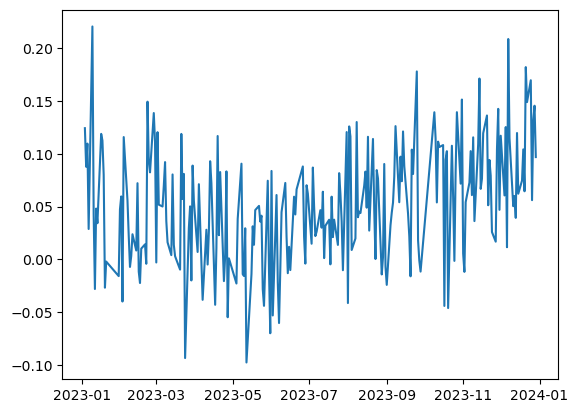

In [12]:
data['OI_momentum_120'] = data['order_imbalance'].diff(120)
plt.plot(cal_ic('OI_momentum_120'))
cal_ic('OI_momentum_120').mean()

计算 Order Imbalance 的累积值，反映一段时间内买卖不平衡的累积效应。累积不平衡度可以帮助判断市场长期的买卖倾向。

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/2013178646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_cumulative_10'] = data['order_imbalance'].rolling(window=10).sum()


0.032700929073152876

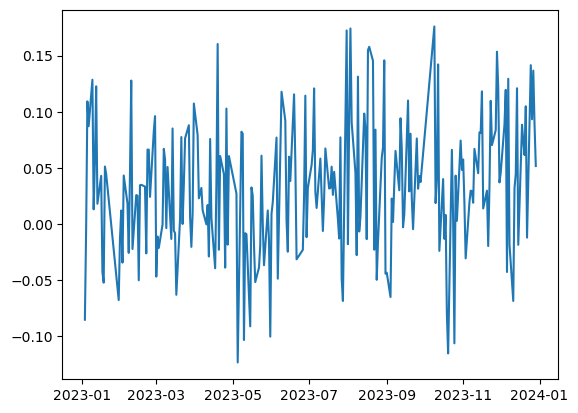

In [13]:
data['OI_cumulative_10'] = data['order_imbalance'].rolling(window=10).sum()
plt.plot(cal_ic('OI_cumulative_10'))
cal_ic('OI_cumulative_10').mean()

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/556743440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OI_cumulative_120'] = data['order_imbalance'].rolling(window=120).sum()


0.016131469335597302

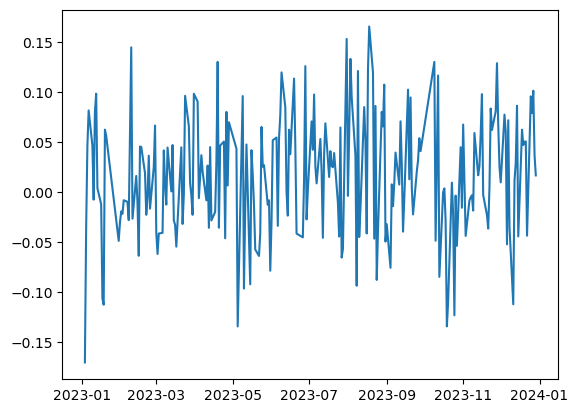

In [14]:
data['OI_cumulative_120'] = data['order_imbalance'].rolling(window=120).sum()
plt.plot(cal_ic('OI_cumulative_120'))
cal_ic('OI_cumulative_120').mean()

市场压力因子通过计算买卖盘价位差异来捕捉买卖双方的压力。这个因子可以揭示价格可能的移动方向。

- 市场压力：

$$
\text{market\_pressure} = \frac{\text{BidPrice1} \cdot \text{BidVolume1} - \text{AskPrice1} \cdot \text{AskVolume1}}{\text{BidPrice1} \cdot \text{BidVolume1} + \text{AskPrice1} \cdot \text{AskVolume1}}
$$

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/114161864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['market_pressure'] = (data['BidPrice1']*data['BidVolume1']-data['AskPrice1']*data['AskVolume1'])/(data['BidPrice1']*data['BidVolume1']+data['AskPrice1']*data['AskVolume1'])


0.10941037233700342

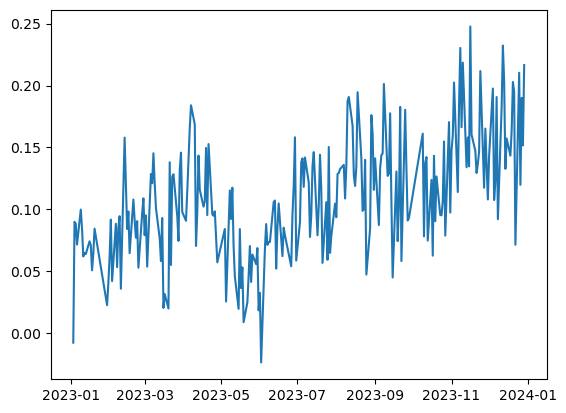

In [15]:
data['market_pressure'] = (data['BidPrice1']*data['BidVolume1']-data['AskPrice1']*data['AskVolume1'])/(data['BidPrice1']*data['BidVolume1']+data['AskPrice1']*data['AskVolume1'])
plt.plot(cal_ic('market_pressure'))
cal_ic('market_pressure').mean()

SOIRi (i=1,2,3,4,5)这一组逐档订单失衡率因子，其中每个因子仅包含第i档的信息。最后，为了充分利用盘口各档数据信息，我们采用衰减加权的方法对SOIRi加权得到SOIR因子，根据对买卖压力的影响力的不同将不同档位赋予相应权重，赋予靠近交易价格档位更高的权重。

In [16]:
data['SOIR1'] = (data['BidVolume1']-data['AskVolume1'])/(data['BidVolume1']+data['AskVolume1'])
data['SOIR2'] = (data['BidVolume2']-data['AskVolume2'])/(data['BidVolume2']+data['AskVolume2'])
data['SOIR3'] = (data['BidVolume3']-data['AskVolume3'])/(data['BidVolume3']+data['AskVolume3'])
data['SOIR4'] = (data['BidVolume4']-data['AskVolume4'])/(data['BidVolume4']+data['AskVolume4'])
data['SOIR5'] = (data['BidVolume5']-data['AskVolume5'])/(data['BidVolume5']+data['AskVolume5'])

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/182890147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1'] = (data['BidVolume1']-data['AskVolume1'])/(data['BidVolume1']+data['AskVolume1'])
/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/182890147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR2'] = (data['BidVolume2']-data['AskVolume2'])/(data['BidVolume2']+data['AskVolume2'])
/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1

0.10941071019675107

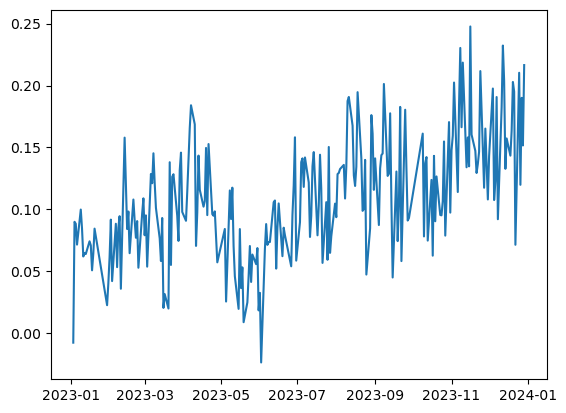

In [17]:
plt.plot(cal_ic('SOIR1'))
cal_ic('SOIR1').mean()

In [18]:
for window_size in [10, 20, 40, 80, 120]:
    data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()
    print('前{}秒SOIR均值与未来一分钟收益率的IC为{}'.format(window_size//2, cal_ic('SOIR1_mean_{}'.format(window_size)).mean()))

/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1499455312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()


前5秒SOIR均值与未来一分钟收益率的IC为0.06167685317488863


/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1499455312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()


前10秒SOIR均值与未来一分钟收益率的IC为0.044598237190359234


/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1499455312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()


前20秒SOIR均值与未来一分钟收益率的IC为0.030414358138703548


/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1499455312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()


前40秒SOIR均值与未来一分钟收益率的IC为0.02008836612724785


/var/folders/l5/7228dqmd1258vhn9bsdpsstr0000gn/T/ipykernel_92327/1499455312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SOIR1_mean_{}'.format(window_size)] = data['SOIR1'].rolling(window_size).mean()


前60秒SOIR均值与未来一分钟收益率的IC为0.015198205120852218


In [19]:
import warnings
warnings.filterwarnings("ignore")

for window_size in [10, 20, 40, 80, 120]:
    data['price_pct_{}'.format(window_size)] = 100*(data['mid_price']-data['mid_price'].shift(window_size))/data['mid_price'].shift(window_size)
    print('前{}秒midprice的变化率与SOIR1因子的相关系数为{}'.format(window_size//2, data.groupby('TradingDay').apply(lambda x: x['SOIR1'].corr(x['price_pct_{}'.format(window_size)])).mean()))

前5秒midprice的变化率与SOIR1因子的相关系数为-0.1821732775054267
前10秒midprice的变化率与SOIR1因子的相关系数为-0.16165652920378007
前20秒midprice的变化率与SOIR1因子的相关系数为-0.13802378720487463
前40秒midprice的变化率与SOIR1因子的相关系数为-0.11428777238245649
前60秒midprice的变化率与SOIR1因子的相关系数为-0.10054094312716307


In [20]:
for window_size in [10, 20, 40, 80, 120]:
    print('前{}秒midprice的变化率与未来一分钟收益率的IC为{}'.format(window_size//2, cal_ic('price_pct_{}'.format(window_size)).mean()))

前5秒midprice的变化率与未来一分钟收益率的IC为-0.03343838519290728
前10秒midprice的变化率与未来一分钟收益率的IC为-0.030470376942363233
前20秒midprice的变化率与未来一分钟收益率的IC为-0.027935019458366676
前40秒midprice的变化率与未来一分钟收益率的IC为-0.028991885012277466
前60秒midprice的变化率与未来一分钟收益率的IC为-0.031222803668600904


In [21]:
for window_size in [10, 20, 40, 80, 120]:
    data['new_factor_1_{}'.format(window_size)] =  data['SOIR1']*(1-data['price_pct_{}'.format(window_size)])
    print(cal_ic('new_factor_1_{}'.format(window_size)).mean())

0.10939414865942527
0.10934773193337952
0.10934788063360734
0.10928786760564903
0.1092043551070705


In [ ]:
import statsmodels.api as sm

window_size = 10
data_tmp = data.dropna(subset=['SOIR1', 'price_pct_{}'.format(window_size), 'label'])
X = data_tmp[['SOIR1', 'price_pct_{}'.format(window_size)]].values
y = data_tmp['label'].values

model = sm.OLS(y, X).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                          3.076e+04
Date:                Fri, 08 Nov 2024   Prob (F-statistic):                        0.00
Time:                        17:49:58   Log-Likelihood:                      2.3930e+07
No. Observations:            10180550   AIC:                                 -4.786e+07
Df Residuals:                10180548   BIC:                                 -4.786e+07
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032   1.32e-05    238.752      0.000       0.003       0.003
x2            -0.0211      0.001    -38.590      0.000      -0.022      -0.020
==============================================================================
Omnibus:                  2885561.361   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        377794672.499
Skew:                           0.096   Prob(JB):                         0.00
Kurtosis:                      32.843   Cond. No.                         41.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
import statsmodels.api as sm

window_size = 120
data_tmp = data.dropna(subset=['SOIR1', 'price_pct_{}'.format(window_size), 'label'])
X = data_tmp[['SOIR1', 'price_pct_{}'.format(window_size)]].values
y = data_tmp['label'].values

model = sm.OLS(y, X).fit()

In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                          3.105e+04
Date:                Fri, 08 Nov 2024   Prob (F-statistic):                        0.00
Time:                        19:05:15   Log-Likelihood:                      2.3930e+07
No. Observations:            10180440   AIC:                                 -4.786e+07
Df Residuals:                10180438   BIC:                                 -4.786e+07
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032   1.32e-05    241.830      0.000       0.003       0.003
x2            -0.0074      0.000    -45.416      0.000      -0.008      -0.007
==============================================================================
Omnibus:                  2886315.850   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        378340242.255
Skew:                           0.096   Prob(JB):                         0.00
Kurtosis:                      32.864   Cond. No.                         12.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
import statsmodels.api as sm

window_size = 120
data_tmp = data.dropna(subset=['SOIR1', 'price_pct_{}'.format(window_size), 'label'])
X = data_tmp[['price_pct_{}'.format(window_size)]].values
y = data_tmp['SOIR1'].values

model = sm.OLS(y, X).fit()

In [83]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                          3.731e+04
Date:                Fri, 08 Nov 2024   Prob (F-statistic):                        0.00
Time:                        20:50:29   Log-Likelihood:                     -8.3403e+06
No. Observations:            10180440   AIC:                                  1.668e+07
Df Residuals:                10180439   BIC:                                  1.668e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7466      0.004   -193.162      0.000      -0.754      -0.739
==============================================================================
Omnibus:                  2520476.068   Durbin-Watson:                   0.312
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           437620.798
Skew:                          -0.035   Prob(JB):                         0.00
Kurtosis:                       1.987   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn.linear_model import LinearRegression

for window_size in [10]:
    data['new_factor_2_{}'.format] = np.nan

    for i in range(129, len(data)):
        X = data[['SOIR1', 'price_pct_{}'.format(window_size)]].iloc[i-119:i].values
        y = data['label'].iloc[i-119:i].values

        model = LinearRegression()
        model.fit(X, y)

        # 使用模型对当前行进行预测
        data.at[i, 'new_factor_2_{}'.format] = model.predict(data[['SOIR1', 'price_pct_{}'.format(window_size)]].iloc[i].values.reshape(1, -1))[0]

In [ ]:
from sklearn.linear_model import LinearRegression

for window_size in [10]:
    data['new_factor_3_{}'.format] = np.nan

    for i in range(129, len(data)):
        X = data[['price_pct_{}'.format(window_size)]].iloc[i-119:i].values
        y = data['SOIR1'].iloc[i-119:i].values

        model = LinearRegression()
        model.fit(X, y)

        # 使用模型对当前行进行预测
        data.at[i, 'new_factor_3_{}'.format] = model.predict(data[['price_pct_{}'.format(window_size)]].iloc[i].values.reshape(1, -1))[0]

In [93]:
new_data = data.dropna(subset=['price_pct_120', 'SOIR1', 'label'])

# Dividing each group into 5 equal-sized quantiles and computing correlations
results = {}
for date, group in new_data.groupby('TradingDay'):
    # print(date)
    # print(group)
    group['quantile'] = pd.qcut(group['price_pct_120'], q=3, labels=False, duplicates='drop')
    corr_values = []
    for quantile in range(3):
        sub_group = group[group['quantile'] == quantile]
        corr = sub_group[['SOIR1', 'label']].corr().iloc[0, 1]  # Correlation between SOIR1 and label
        # if np.isnan(corr):
        #     print(len(sub_group[['SOIR1', 'label']]))
        corr_values.append(corr)
    results[date] = corr_values

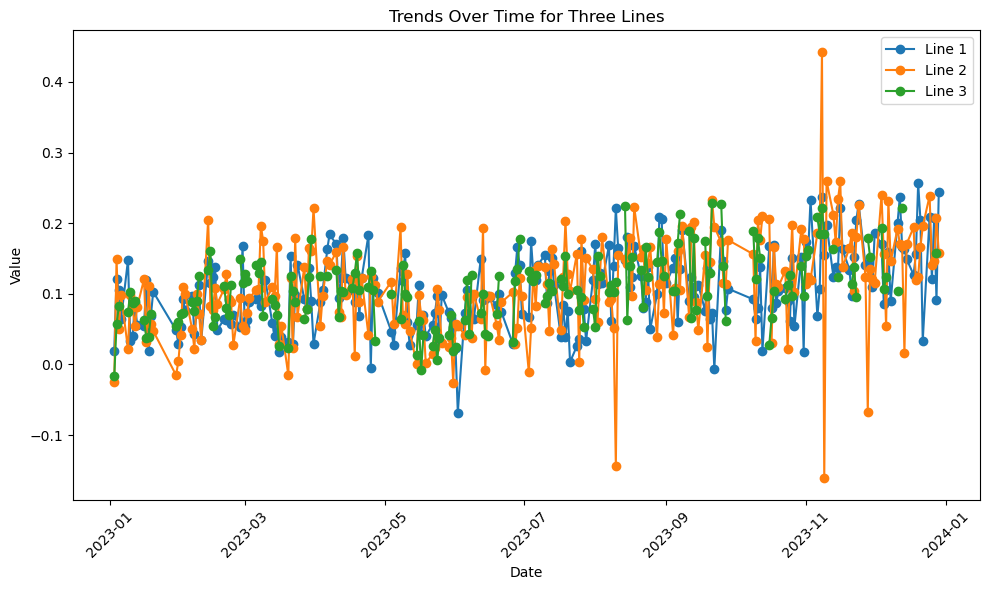

In [94]:
dates = list(results.keys())
values = list(results.values())

# Plotting the data
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(dates, [value[i] for value in values], marker='o', label=f'Line {i+1}')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends Over Time for Three Lines')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
a = [i[0] for i in values]
b = [i[1] for i in values]
c = np.array([i[2] for i in values])
print(sum(a) / len(a))
print(sum(b) / len(b))
print(np.nanmean(c))

0.10633637161108421
0.10989021879317759
0.10713113616533348


In [84]:
new_data = data.dropna(subset=['price_pct_120', 'SOIR1', 'label'])

# Dividing each group into 5 equal-sized quantiles and computing correlations
results = {}
for date, group in new_data.groupby('TradingDay'):
    # print(date)
    # print(group)
    group['quantile'] = pd.qcut(group['price_pct_120'], q=2, labels=False, duplicates='drop')
    corr_values = []
    for quantile in range(2):
        sub_group = group[group['quantile'] == quantile]
        corr = sub_group[['SOIR1', 'label']].corr().iloc[0, 1]  # Correlation between SOIR1 and label
        # if np.isnan(corr):
        #     print(len(sub_group[['SOIR1', 'label']]))
        corr_values.append(corr)
    results[date] = corr_values

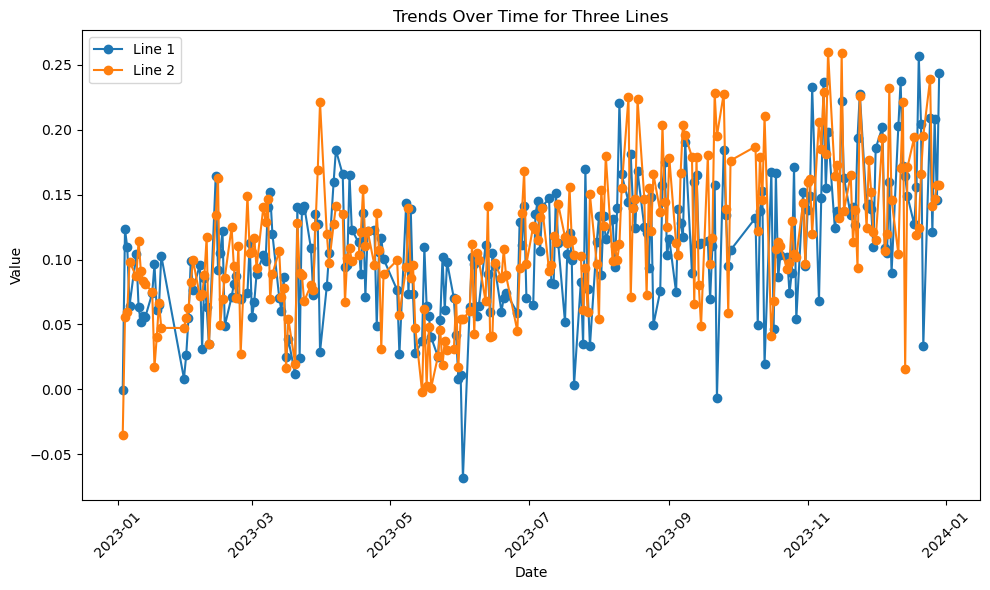

In [86]:
dates = list(results.keys())
values = list(results.values())

# Plotting the data
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(dates, [value[i] for value in values], marker='o', label=f'Line {i+1}')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends Over Time for Three Lines')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
a = [i[0] for i in values]
b = [i[1] for i in values]
print(sum(a) / len(a))
print(sum(b) / len(b))

0.10727553373144903
0.11286120822627713
